In [68]:
import numpy as np

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape, BatchNormalization
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt

In [66]:
class Discriminator(Model):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(32, activation='relu')
        self.dense_3 = Dense(32, activation='relu')
        self.flat_layer = Flatten()
        self.output_layer = Dense(10, activation='softmax')
        
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.flat_layer(x)
        output = self.output_layer(x)
        return output
    
    
class Generator(Model):
    def __init__(self, **kwargs):
        super(Generator, self).__init__(**kwargs)
        self.dense_1 = Dense(7*7*256, activation='relu', input_shape=(100,), name='dense_1')
        self.reshape = Reshape((7, 7, 256), name='reshape')
        
        self.conv2dt_1 = Conv2DTranspose(128, (3, 3), strides=1, padding='same', name='conv2dt_1')
        self.bn1 = BatchNormalization(name='bn1')
        
        self.conv2dt_2 = Conv2DTranspose(64, (3, 3), strides=2, padding='same', name='conv2dt_2')
        self.bn2 = BatchNormalization(name='bn2')
        
        self.conv2dt_3 = Conv2DTranspose(1, (3, 3), strides=2, padding='same', 
                                         activation='tanh', name='conv2dt_3')
        
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.reshape(x)
        x = self.conv2dt_1(x)
        x = self.bn1(x)
        x = self.conv2dt_2(x)
        x = self.bn2(x)
        output = self.conv2dt_3(x)
        return output
    
    
class GAN(Model):
    def __init__(self, latent_dim, **kwargs):
        super(GAN, self).__init__(**kwargs)
        self.discriminator = Discriminator()
        self.generator = Generator()
        self.latent_dim
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    def train_step(self, data):
        batch_size = tf.shape(data)[0]
        fake_img = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_img = self.generator(fake_img)
        both_img = tf.concatenate([fake_img, data], axis=0)
        labels = tf.concatenate([tf.ones(batch_size, 1),
                                 tf.zeros(batch_size, 0)],
                                axis=0)
        labels += 0.05 * tf.random.uniform(shape=(2 * batch_size, 1))
        
        with GradientTape() as tape:
            preds = self.discriminator(both_img)
            self.loss_fn(labels, preds)
            
        

In [36]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [38]:
model = Discriminator()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.fit(x_train, y_train, epochs=10, batch_size=254, validation_data=(x_test, y_test))

Epoch 1/10
237/237 [==============================] - 2s 9ms/step - loss: 2.3155 - accuracy: 0.7229 - val_loss: 0.4445 - val_accuracy: 0.8743
Epoch 2/10
237/237 [==============================] - 2s 9ms/step - loss: 0.3557 - accuracy: 0.8969 - val_loss: 0.2720 - val_accuracy: 0.9177
Epoch 3/10
237/237 [==============================] - 2s 8ms/step - loss: 0.2444 - accuracy: 0.9274 - val_loss: 0.2167 - val_accuracy: 0.9352
Epoch 4/10
237/237 [==============================] - 2s 8ms/step - loss: 0.1960 - accuracy: 0.9399 - val_loss: 0.1922 - val_accuracy: 0.9435
Epoch 5/10
237/237 [==============================] - 2s 9ms/step - loss: 0.1688 - accuracy: 0.9490 - val_loss: 0.1718 - val_accuracy: 0.9460
Epoch 6/10
237/237 [==============================] - 2s 8ms/step - loss: 0.1502 - accuracy: 0.9538 - val_loss: 0.1688 - val_accuracy: 0.9471
Epoch 7/10
237/237 [==============================] - 2s 8ms/step - loss: 0.1390 - accuracy: 0.9577 - val_loss: 0.1570 - val_accuracy: 0.9511
Epoch 

In [72]:
test_arr = tf.random.normal((500, 100))
generator = Generator()
res = generator(test_arr)

In [80]:
gen_res = res[0].numpy().squeeze()

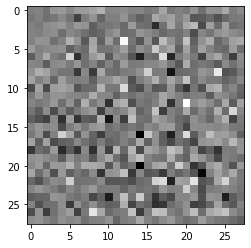

In [83]:
plt.imshow(gen_res, cmap='gray_r')

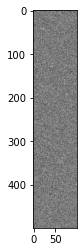

In [86]:
plt.imshow(test_arr, cmap='gray_r')